In [24]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [25]:
# Load the dataset
data = load_diabetes()
X = data.data
y = data.target

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

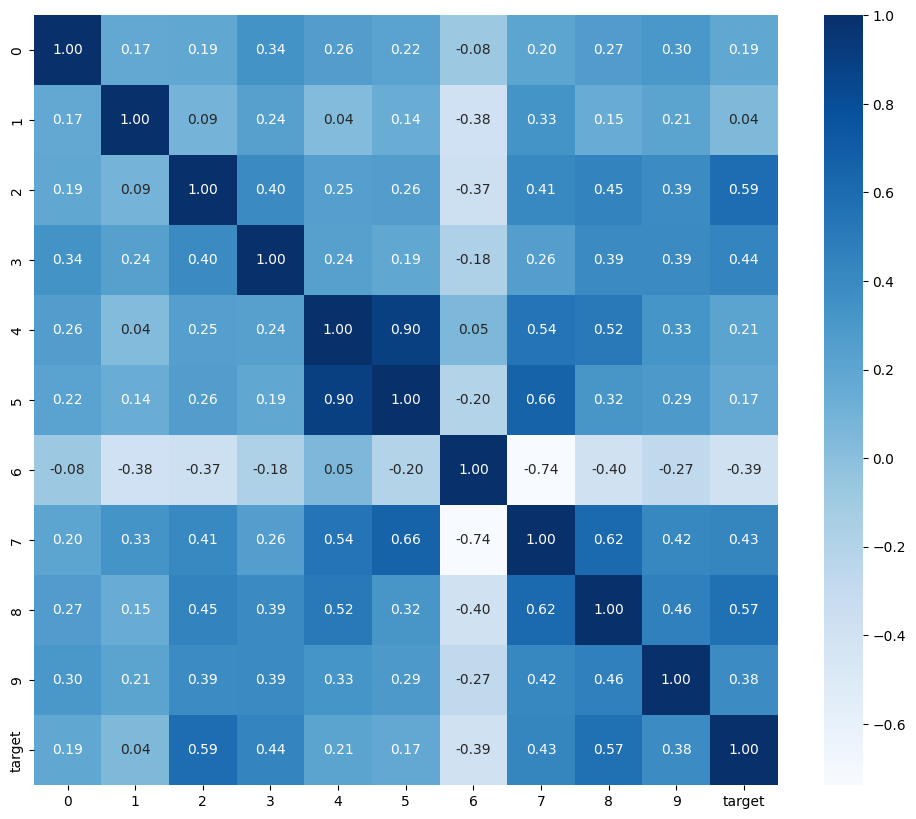

In [27]:
# Visualization
plt.figure(figsize=(12, 10))
# Convert X and y to DataFrames before concatenation
df_X = pd.DataFrame(X)
df_y = pd.DataFrame(y, columns=['target'])  # Give y a column name
sns.heatmap(pd.concat([df_X, df_y], axis=1).corr(), annot=True, cmap='Blues', fmt='.2f')
plt.show()

In [28]:
class TreeNode:
    def __init__(self):
        self.feature = None
        self.threshold = None
        self.left = None
        self.right = None
        self.value = None

import numpy as np
from sklearn.metrics import r2_score

class Node:
    def __init__(self):
        self.feature = None
        self.threshold = None
        self.left = None
        self.right = None
        self.label = None

class CART:
    def __init__(self, max_depth=None, min_samples=2, feature_subset_size=None):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.root = None
        self.feature_subset_size = feature_subset_size
        self.feature_names_ = None  # Store feature names for prediction

    def fit(self, features, target, feature_names=None):
        self.n_features_ = features.shape[1]
        if self.feature_subset_size == 'sqrt':
            self.feature_subset_size = int(np.sqrt(self.n_features_))

        self.feature_names_ = feature_names  # Store feature names during fit
        self.root = self.build_tree(features, target, depth=0)

    def build_tree(self, features, target, depth):
        cur_node = Node()
        no_of_samples = features.shape[0]

        if (len(np.unique(target)) == 1 or
            no_of_samples < self.min_samples or
            (self.max_depth is not None and depth >= self.max_depth)):
            cur_node.label = np.mean(target)
            return cur_node

        split_feature_dict = self.get_best_feature(features, target)
        if split_feature_dict is None:
            cur_node.label = np.mean(target)
            return cur_node

        feature_ind = split_feature_dict['feature_ind']
        threshold = split_feature_dict['threshold']
        features_left, target_left = features[features[:, feature_ind] < threshold], target[features[:, feature_ind] < threshold]
        features_right, target_right = features[features[:, feature_ind] >= threshold], target[features[:, feature_ind] >= threshold]

        cur_node.feature = feature_ind
        cur_node.threshold = threshold
        cur_node.left = self.build_tree(features_left, target_left, depth + 1)
        cur_node.right = self.build_tree(features_right, target_right, depth + 1)
        return cur_node

    def get_best_feature(self, features, target):
        no_of_samples = features.shape[0]
        num_features = features.shape[1]

        selected_features = range(num_features) if self.feature_subset_size is None else np.random.choice(num_features, self.feature_subset_size, replace=False)

        best_mse, best_feature, best_threshold = float('inf'), None, None
        for feature_ind in selected_features:
            feature_values = np.unique(features[:, feature_ind])
            thresholds = (feature_values[:-1] + feature_values[1:]) / 2
            for threshold in thresholds:
                target_left, target_right = target[features[:, feature_ind] < threshold], target[features[:, feature_ind] >= threshold]
                if len(target_left) == 0 or len(target_right) == 0:
                    continue

                mse_left = np.mean((target_left - np.mean(target_left)) ** 2)
                mse_right = np.mean((target_right - np.mean(target_right)) ** 2)
                cur_mse = (len(target_left) / no_of_samples) * mse_left + (len(target_right) / no_of_samples) * mse_right

                if cur_mse < best_mse:
                    best_mse, best_feature, best_threshold = cur_mse, feature_ind, threshold

        return None if best_feature is None else {'feature_ind': best_feature, 'threshold': best_threshold}

    def predict(self, X):
        return np.array([self._predict_single_input(x, self.root) for x in X])

    def _predict_single_input(self, x, node):
        if node.label is not None:
            return node.label
        return self._predict_single_input(x, node.left) if x[node.feature] < node.threshold else self._predict_single_input(x, node.right)


class RandomForest:
    def __init__(self, n_trees=100, max_depth=None, max_features='sqrt'):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        self.oob_indices = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        for _ in range(self.n_trees):
            tree = CART(max_depth=self.max_depth, feature_subset_size=self.max_features)
            indices = np.random.choice(n_samples, n_samples, replace=True)
            oob_indices = np.setdiff1d(np.arange(n_samples), indices)
            tree.fit(X[indices], y[indices])
            self.trees.append(tree)
            self.oob_indices.append(oob_indices)

    def predict(self, X):
        all_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(all_preds, axis=0)


    def oob_error(self, X, y):
        oob_predictions = np.zeros(X.shape[0])
        counts = np.zeros(X.shape[0])

        for i, tree in enumerate(self.trees):
            oob_idx = self.oob_indices[i]
            oob_preds = tree.predict(X[oob_idx])
            oob_predictions[oob_idx] += oob_preds
            counts[oob_idx] += 1

        # Only consider samples that have OOB predictions
        valid_oob = counts > 0
        oob_predictions[valid_oob] /= counts[valid_oob]

        # Calculate R² score for OOB predictions
        oob_score = r2_score(y[valid_oob], oob_predictions[valid_oob])
        return oob_score



In [29]:
# Custom RF Testing and OOB error calculation
params = [50, 100, 150]
best_score = float('inf')
best_param = None
best_oob = float('inf')

for n in params:
    rf = RandomForest(n_trees=n, max_depth=10)
    rf.fit(X_train, y_train)
    test_preds = rf.predict(X_test)
    test_mse = mean_squared_error(y_test, test_preds)
    oob_error = rf.oob_error(X_train, y_train)

    print(f"Custom RF with {n} trees - Test MSE: {test_mse}, OOB Error: {oob_error}")

    if test_mse < best_score:
        best_score = test_mse
        best_param = n
        best_oob = oob_error

print(f"Best Parameters from Custom RF: {best_param}, Best Test MSE: {best_score}, Best OOB Error: {best_oob}")

# Scikit-Learn RandomForestRegressor comparison
sk_rf = RandomForestRegressor(oob_score=True, random_state=42)
grid = GridSearchCV(sk_rf, {'n_estimators': [50, 100, 150]}, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
best_sk_rf = grid.best_estimator_

y_pred_sk = best_sk_rf.predict(X_test)
mse_sk = mean_squared_error(y_test, y_pred_sk)
print(f"Scikit-Learn RF - Best Parameters: {best_sk_rf.n_estimators}, Test MSE: {mse_sk}, OOB Score: {best_sk_rf.oob_score_}")


Custom RF with 50 trees - Test MSE: 3088.4133887068197, OOB Error: 0.44431860593578976
Custom RF with 100 trees - Test MSE: 2821.9030406529473, OOB Error: 0.41104394012074863
Custom RF with 150 trees - Test MSE: 2855.783482019457, OOB Error: 0.432001683924657
Best Parameters from Custom RF: 100, Best Test MSE: 2821.9030406529473, Best OOB Error: 0.41104394012074863
Scikit-Learn RF - Best Parameters: 150, Test MSE: 2994.666187765293, OOB Score: 0.44304981411695366


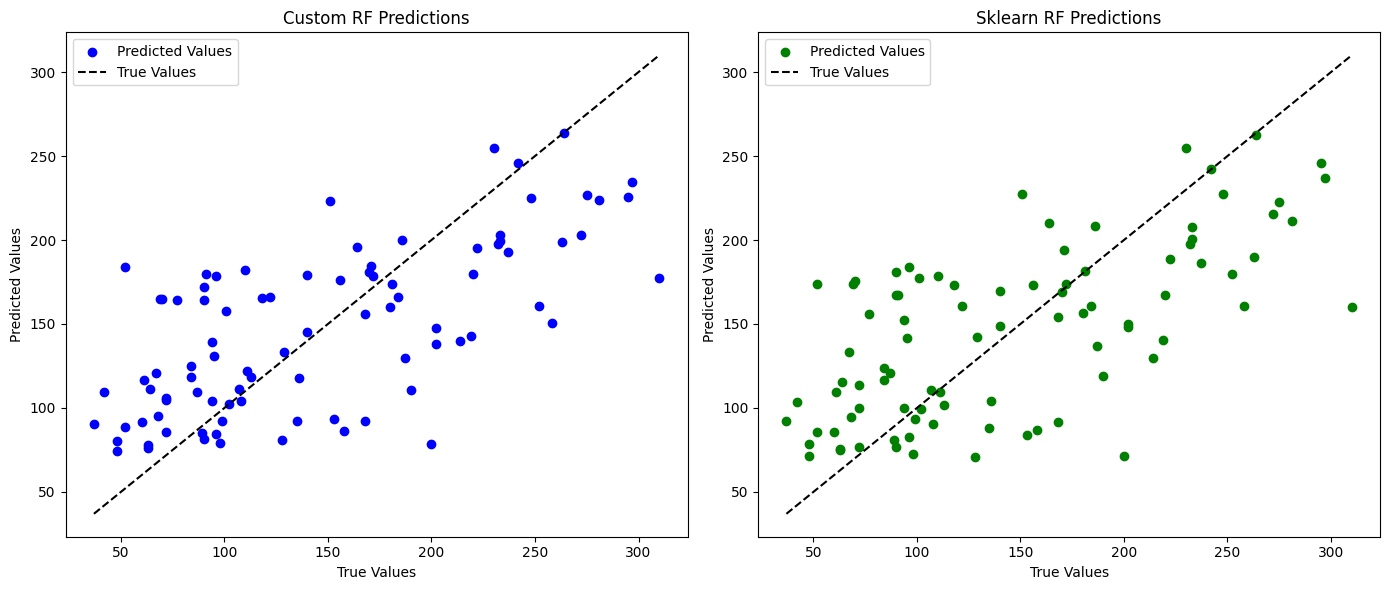

In [30]:
# Visualization
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Custom RF Predictions
axs[0].scatter(y_test, rf.predict(X_test), color='blue', label='Predicted Values')
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='True Values')
axs[0].set_title('Custom RF Predictions')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predicted Values')
axs[0].legend()

# Sklearn RF Predictions
axs[1].scatter(y_test, y_pred_sk, color='green', label='Predicted Values')
axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='True Values')
axs[1].set_title('Sklearn RF Predictions')
axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predicted Values')
axs[1].legend()

plt.tight_layout()
plt.show()